# Transfer Learning 인라인 방식 - 개-고양이 분류 프로젝트

이 노트북은 VGG19 사전학습 모델을 사용한 **인라인(Inline) 방식**의 Transfer Learning으로 개와 고양이 이미지를 분류하는 프로젝트입니다.

## 프로젝트 개요
- **목표**: VGG19 사전학습 모델을 활용한 개-고양이 이진 분류
- **방법**: Transfer Learning (인라인 방식)
- **데이터**: Cats and Dogs 데이터셋
- **프레임워크**: TensorFlow/Keras

## 인라인 방식 vs 투스테이지 방식

### 🔄 인라인 방식 (이 프로젝트)
- **방법**: VGG19를 전체 모델에 포함시켜 end-to-end 학습
- **장점**: 
  - 원본 이미지에 데이터 증강이 직접 적용
  - 과적합 방지 효과
  - 실무에서 가장 많이 사용되는 방식
- **단점**: 투스테이지 방식보다 학습 속도가 느림

### ⚡ 투스테이지 방식 (이전 프로젝트)
- **방법**: VGG19 특성을 미리 추출하여 numpy 배열로 저장 → 분류 학습
- **장점**: 훈련 속도가 매우 빠름
- **단점**: 메모리 사용량 많음, 데이터 증강 제한적

## 프로젝트 구조
1. 라이브러리 임포트 및 환경 설정
2. 데이터 전처리 및 분할
3. VGG19 인라인 모델 구축
4. 모델 학습 및 저장
5. 결과 분석 및 비교


## 1. 라이브러리 임포트 및 환경 설정

필요한 라이브러리들을 임포트합니다.


In [2]:
# 딥러닝 관련 라이브러리
import tensorflow as tf
import keras
from keras.applications.vgg19 import VGG19
from keras import models, layers
from keras.utils import image_dataset_from_directory

# 데이터 처리 및 시각화 라이브러리
import numpy as np
import matplotlib.pyplot as plt
import pickle

# 파일 시스템 관련 라이브러리
import os
import shutil
import pathlib
import gdown  # 구글 드라이브에서 데이터 다운로드용

print("라이브러리 임포트 완료!")
print(f"TensorFlow 버전: {tf.__version__}")
print(f"Keras 버전: {keras.__version__}")

# 경고 메시지 제거 (선택사항)
import warnings
warnings.filterwarnings('ignore')


라이브러리 임포트 완료!
TensorFlow 버전: 2.15.1
Keras 버전: 2.15.0


## 2. 데이터 전처리 및 분할

Cats and Dogs 데이터셋을 Train/Validation/Test로 분할하고 데이터 로더를 생성합니다.

### 데이터 구조:
- **원본**: `cats_and_dogs/train/` (총 25,000장)
- **분할 후**: 
  - Train: 0~999번 이미지 (각 클래스 1,000장)
  - Validation: 1000~1499번 이미지 (각 클래스 500장)
  - Test: 1500~1999번 이미지 (각 클래스 500장)

### 폴더 구조:
```
cats_and_dogs_small/
├── train/
│   ├── cat/    # 자동 라벨링: 0
│   └── dog/    # 자동 라벨링: 1
├── validation/
│   ├── cat/
│   └── dog/
└── test/
    ├── cat/
    └── dog/
```

**중요**: 케라스는 폴더 이름을 오름차순으로 정렬하여 자동 라벨링합니다!


In [3]:
# 데이터셋 경로 설정
original_dir = pathlib.Path("../../data/cats_and_dogs/train")
new_base_dir = pathlib.Path("../../data/cats_and_dogs/cats_and_dogs_small")

print("📁 데이터셋 경로 설정 완료!")
print(f"원본 데이터: {original_dir}")
print(f"분할 저장: {new_base_dir}")

# 선택사항: 구글 드라이브에서 데이터 다운로드
# gdown.download(id='18uC7WTuEXKJDDxbj-Jq6EjzpFrgE7IAd', output='dogs-vs-cats.zip')


📁 데이터셋 경로 설정 완료!
원본 데이터: ..\..\data\cats_and_dogs\train
분할 저장: ..\..\data\cats_and_dogs\cats_and_dogs_small


In [4]:
def make_subset(subset_name, start_index, end_index):
    """
    특정 범위의 이미지들을 지정된 폴더로 복사
    
    Args:
        subset_name: 'train', 'validation', 'test'
        start_index: 시작 인덱스
        end_index: 끝 인덱스 (포함되지 않음)
    """
    for category in ("cat", "dog"):
        # 목적지 폴더 생성 (WindowsPath 객체 사용)
        dir_path = new_base_dir / subset_name / category
        os.makedirs(dir_path, exist_ok=True)
        
        # 파일명 리스트 생성 (예: cat.0.jpg, cat.1.jpg, ...)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        
        # 파일 복사
        for fname in fnames:
            src_path = original_dir / fname
            dst_path = dir_path / fname
            if src_path.exists():  # 원본 파일이 존재하는 경우에만 복사
                shutil.copyfile(src_path, dst_path)
        
        print(f"✅ {subset_name}/{category}: {len(fnames)}개 이미지 복사 완료")

print("데이터 분할 함수 정의 완료!")


데이터 분할 함수 정의 완료!


In [5]:
# 데이터 분할 실행
print("🔄 데이터 분할 시작...")

# Train 세트: 각 클래스 1,000장 (0~999)
make_subset("train", 0, 1000)

# Validation 세트: 각 클래스 500장 (1000~1499)
make_subset("validation", 1000, 1500)

# Test 세트: 각 클래스 500장 (1500~1999)
make_subset("test", 1500, 2000)

print("\n✅ 모든 데이터 분할 완료!")
print(f"📊 총 데이터: Train({1000*2}), Validation({500*2}), Test({500*2})")


🔄 데이터 분할 시작...
✅ train/cat: 1000개 이미지 복사 완료
✅ train/dog: 1000개 이미지 복사 완료
✅ validation/cat: 500개 이미지 복사 완료
✅ validation/dog: 500개 이미지 복사 완료
✅ test/cat: 500개 이미지 복사 완료
✅ test/dog: 500개 이미지 복사 완료

✅ 모든 데이터 분할 완료!
📊 총 데이터: Train(2000), Validation(1000), Test(1000)


In [6]:
# 데이터셋 로더 생성
# batch_size에 지정된 만큼 폴더로부터 이미지를 읽어옵니다.
# image_size에 지정한 크기로 자동 리사이징됩니다.

train_ds = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=16,
    label_mode='binary'  # 이진 분류 (0: cat, 1: dog)
)

validation_ds = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=16,
    label_mode='binary'
)

test_ds = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=16,
    label_mode='binary'
)

print("✅ 데이터셋 로더 생성 완료!")
print(f"📁 Train: {train_ds}")
print(f"📁 Validation: {validation_ds}")
print(f"📁 Test: {test_ds}")

# 클래스 이름 확인 (알파벳 순서로 자동 라벨링)
class_names = train_ds.class_names
print(f"🏷️ 클래스: {class_names}")  # ['cat', 'dog'] → [0, 1]


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
✅ 데이터셋 로더 생성 완료!
📁 Train: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>
📁 Validation: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>
📁 Test: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>
🏷️ 클래스: ['cat', 'dog']


## 3. VGG19 인라인 모델 구축

VGG19 사전학습 모델을 전체 모델에 포함시켜 end-to-end 학습이 가능한 모델을 구축합니다.

### 인라인 방식의 특징:
1. **모델 통합**: VGG19가 전체 모델의 일부가 됨
2. **실시간 전처리**: 원본 이미지에 직접 데이터 증강 적용
3. **동결 학습**: VGG19 가중치는 고정, 분류층만 학습
4. **End-to-End**: 입력부터 출력까지 하나의 모델로 처리

### 모델 구조:
```
입력 이미지 (180x180x3)
    ↓
데이터 증강 (RandomFlip, RandomRotation, RandomZoom)
    ↓
VGG19 전처리 (ImageNet 정규화)
    ↓
VGG19 CNN (동결) → 특성 추출 (5x5x512)
    ↓
Flatten → Dense(256) → Dense(128) → Dense(64) → Dense(1, sigmoid)
```


In [8]:
def create_inline_model():
    """
    VGG19를 포함한 인라인 방식의 Transfer Learning 모델 생성
    
    Returns:
        keras.Model: 컴파일된 인라인 모델
    """
    print("🔧 VGG19 사전학습 모델 로드 중...")
    
    # VGG19 사전학습 모델 로드
    conv_base = keras.applications.vgg19.VGG19(
        weights="imagenet",        # ImageNet 가중치 사용
        include_top=False,         # 상단 분류층 제외 (CNN 부분만)
        input_shape=(180, 180, 3)  # 입력 크기는 데이터셋과 일치해야 함
    )
    
    print("📊 VGG19 모델 정보:")
    print(f"   입력 크기: {conv_base.input_shape}")
    print(f"   출력 크기: {conv_base.output_shape}")
    
    # VGG19 가중치 동결 상태 확인
    conv_base.trainable = True
    print(f"   동결 전 훈련 가능한 가중치: {len(conv_base.trainable_weights)}개")
    
    conv_base.trainable = False  # VGG19 가중치 동결
    print(f"   동결 후 훈련 가능한 가중치: {len(conv_base.trainable_weights)}개")
    
    print("✅ VGG19 가중치 동결 완료! (특성 추출기로만 사용)")
    
    return conv_base

# VGG19 모델 생성
conv_base = create_inline_model()

# VGG19 구조 확인
print("\n📋 VGG19 모델 구조 요약:")
conv_base.summary()


🔧 VGG19 사전학습 모델 로드 중...
📊 VGG19 모델 정보:
   입력 크기: (None, 180, 180, 3)
   출력 크기: (None, 5, 5, 512)
   동결 전 훈련 가능한 가중치: 32개
   동결 후 훈련 가능한 가중치: 0개
✅ VGG19 가중치 동결 완료! (특성 추출기로만 사용)

📋 VGG19 모델 구조 요약:
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                               

In [10]:
def build_complete_model(conv_base):
    """
    VGG19 기반의 완전한 인라인 모델 구축
    
    Args:
        conv_base: 동결된 VGG19 모델
        
    Returns:
        keras.Model: 완성된 인라인 모델
    """
    print("🏗️ 인라인 모델 구축 중...")
    
    # 데이터 증강 레이어 정의
    data_augmentation = keras.Sequential([
        layers.RandomFlip("horizontal"),      # 수평 뒤집기
        layers.RandomRotation(0.2),          # ±20% 회전 (72도)
        layers.RandomZoom(0.4),              # ±40% 확대/축소
    ], name="data_augmentation")
    
    # 전체 모델 구축
    inputs = keras.Input(shape=(180, 180, 3), name="input_layer")
    
    # 1. 데이터 증강 적용 (원본 이미지에 직접 적용!)
    x = data_augmentation(inputs)
    
    # 2. VGG19 전처리 (ImageNet 정규화)
    x = keras.applications.vgg19.preprocess_input(x)
    
    # 3. VGG19 특성 추출 (동결된 상태)
    x = conv_base(x)  # 시간이 오래 걸리지만 더 정확한 특성 추출
    
    # 4. 분류 네트워크
    x = layers.Flatten(name="flatten")(x)
    x = layers.Dense(256, activation="relu", name="dense_256")(x)
    x = layers.Dense(128, activation="relu", name="dense_128")(x)
    x = layers.Dense(64, activation="relu", name="dense_64")(x)
    outputs = layers.Dense(1, activation="sigmoid", name="output")(x)
    
    # 모델 생성
    model = keras.Model(inputs, outputs, name="VGG19_Inline_Model")
    
    # 모델 컴파일
    model.compile(
        loss="binary_crossentropy",
        optimizer="rmsprop",
        metrics=["accuracy"]
    )
    
    print("✅ 인라인 모델 구축 완료!")
    return model

# 완전한 모델 구축
model = build_complete_model(conv_base)

print("\n📋 완성된 모델 구조:")
model.summary()


🏗️ 인라인 모델 구축 중...
✅ 인라인 모델 구축 완료!

📋 완성된 모델 구조:
Model: "VGG19_Inline_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 180, 180, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, 180, 180, 3)       0         
 ial)                                                            
                                                                 
 tf.__operators__.getitem_1  (None, 180, 180, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 180, 180, 3)       0         
 da)                                                             
                                                                 
 vgg19 (Functional)          (None, 5, 5, 512)         20024384  


## 4. 모델 학습 및 저장

구축된 인라인 모델을 학습시키고 최적 모델을 자동 저장합니다.

### 학습 설정:
- **에포크**: 10회 반복 학습
- **데이터**: 원본 이미지에 실시간 증강 적용
- **콜백**: ModelCheckpoint로 최적 모델 자동 저장
- **모니터링**: 검증 손실(val_loss) 기준으로 최적 모델 선정

### 인라인 방식의 장점:
1. **실시간 증강**: 매번 다른 증강된 이미지로 학습
2. **과적합 방지**: 데이터 증강으로 일반화 성능 향상
3. **end-to-end**: 입력부터 출력까지 하나의 파이프라인


In [ ]:
def train_inline_model(model, train_ds, validation_ds, epochs=10):
    """
    인라인 모델 학습 함수
    
    Args:
        model: 컴파일된 keras 모델
        train_ds: 훈련 데이터셋
        validation_ds: 검증 데이터셋
        epochs: 학습 에포크 수
        
    Returns:
        history: 학습 기록
    """
    print("🚀 인라인 모델 학습 시작...")
    print(f"   에포크: {epochs}회")
    print("   ※ 인라인 방식은 시간이 오래 걸릴 수 있습니다.")
    
    # 콜백 설정 (최적 모델 자동 저장)
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath="../../data/Cats_and_Dogs_Pre-Learning_weights.h5",
            save_weights_only=True,      # 가중치만 저장 (더 안전함)
            save_best_only=True,
            monitor='val_accuracy',
            mode='max',
            verbose=1
        )
    ]
    
    # 모델 학습
    history = model.fit(
        train_ds,                    # 훈련 데이터
        epochs=epochs,               # 에포크 수
        validation_data=validation_ds, # 검증 데이터
        callbacks=callbacks,         # 콜백 함수
        verbose=1                    # 학습 과정 출력
    )
    
    print("✅ 모델 학습 완료!")
    
    # 학습 기록 저장
    with open("../../data/Cats_and_Dogs_Pre-Learning.bin", "wb") as file:
        pickle.dump(history.history, file)
    print("💾 학습 기록 저장 완료: Cats_and_Dogs_Pre-Learning.bin")
    
    return history

# 모델 학습 실행
history = train_inline_model(model, train_ds, validation_ds, epochs=10)

## 5. 결과 분석 및 시각화

학습 과정과 결과를 시각화하고 분석합니다.


📈 인라인 방식 학습 과정 시각화:


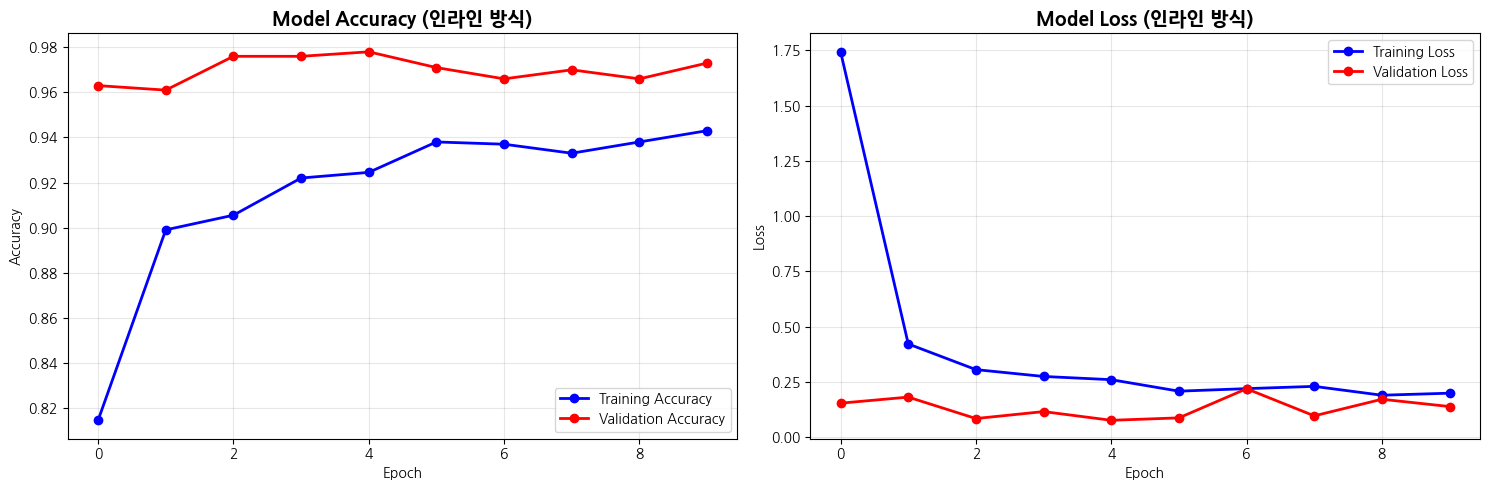

📊 최종 학습 결과:
   훈련 정확도: 0.9430 (94.30%)
   검증 정확도: 0.9730 (97.30%)
   훈련 손실: 0.1981
   검증 손실: 0.1376


In [12]:
def plot_training_results(history):
    """
    학습 과정의 정확도와 손실을 시각화
    
    Args:
        history: model.fit()에서 반환된 History 객체 또는 딕셔너리
    """
    
    if history is None:
        print("❌ 학습 기록이 없습니다.")
        return
    
    # history 객체에서 딕셔너리 추출
    if hasattr(history, 'history'):
        hist_dict = history.history
    else:
        hist_dict = history
    
    
    # 한글 폰트 설정 (나눔고딕)
    plt.rcParams['font.family'] = 'NanumGothic'
    plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # 정확도 그래프
    ax1.plot(hist_dict['accuracy'], 'bo-', label='Training Accuracy', linewidth=2)
    ax1.plot(hist_dict['val_accuracy'], 'ro-', label='Validation Accuracy', linewidth=2)
    ax1.set_title('Model Accuracy (인라인 방식)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 손실 그래프
    ax2.plot(hist_dict['loss'], 'bo-', label='Training Loss', linewidth=2)
    ax2.plot(hist_dict['val_loss'], 'ro-', label='Validation Loss', linewidth=2)
    ax2.set_title('Model Loss (인라인 방식)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 최종 성능 출력
    final_train_acc = hist_dict['accuracy'][-1]
    final_val_acc = hist_dict['val_accuracy'][-1]
    final_train_loss = hist_dict['loss'][-1]
    final_val_loss = hist_dict['val_loss'][-1]
    
    print("📊 최종 학습 결과:")
    print(f"   훈련 정확도: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
    print(f"   검증 정확도: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
    print(f"   훈련 손실: {final_train_loss:.4f}")
    print(f"   검증 손실: {final_val_loss:.4f}")

# 학습 결과 시각화
if 'history' in locals() and history is not None:
    print("📈 인라인 방식 학습 과정 시각화:")
    plot_training_results(history)
else:
    print("ℹ️ 학습 기록을 시각화하려면 먼저 모델을 학습하세요.")


In [ ]:
def evaluate_model_on_test(model_path="Cats_and_Dogs_Pre-Learning_weights.h5"):
    """
    저장된 모델을 로드하여 테스트 데이터로 평가
    
    Args:
        model_path: 저장된 모델 파일 경로
    """
    try:
        # 먼저 모델 구조를 다시 생성해야 합니다
        print("📥 모델 구조 재생성 중...")
        
        # VGG19 모델 다시 생성
        conv_base = keras.applications.vgg19.VGG19(
            weights="imagenet",
            include_top=False,
            input_shape=(180, 180, 3)
        )
        conv_base.trainable = False
        
        # 완전한 모델 다시 구축
        best_model = build_complete_model(conv_base)
        
        # 저장된 가중치 로드
        print("📥 저장된 가중치 로드 중...")
        best_model.load_weights(model_path)
        print("✅ 가중치 로드 완료!")
        
        # 테스트 데이터로 평가
        print("🔍 테스트 데이터 평가 중...")
        test_loss, test_accuracy = best_model.evaluate(test_ds, verbose=1)
        
        print(f"\n🎯 테스트 결과:")
        print(f"   테스트 손실: {test_loss:.4f}")
        print(f"   테스트 정확도: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
        
        return best_model, test_accuracy
        
    except FileNotFoundError:
        print("❌ 저장된 가중치 파일이 없습니다. 먼저 모델을 학습하세요!")
        return None, None
    except Exception as e:
        print(f"❌ 모델 로드 중 오류 발생: {e}")
        print("💡 해결 방법: 모델을 다시 학습하거나 전체 모델 저장 방식으로 변경하세요.")
        return None, None

# 테스트 평가 실행
print("🧪 테스트 데이터로 최종 평가:")
best_model, test_acc = evaluate_model_on_test()

## 6. 결론 및 인라인 vs 투스테이지 비교

### 완료된 작업:
✅ **인라인 Transfer Learning 구현**: VGG19를 전체 모델에 통합  
✅ **실시간 데이터 증강**: 원본 이미지에 직접 적용  
✅ **End-to-End 학습**: 입력부터 출력까지 하나의 파이프라인  
✅ **모델 최적화**: ModelCheckpoint로 최적 모델 자동 저장  
✅ **성능 평가**: 테스트 데이터로 최종 정확도 측정  

### 🔄 인라인 방식 vs ⚡ 투스테이지 방식 비교

| 특성 | 인라인 방식 (이 프로젝트) | 투스테이지 방식 (이전 프로젝트) |
|------|---------------------------|--------------------------------|
| **학습 속도** | 느림 (실시간 VGG19 처리) | 빠름 (사전 추출된 특성 사용) |
| **메모리 사용** | 적음 (배치별 처리) | 많음 (모든 특성을 메모리에 저장) |
| **데이터 증강** | 원본 이미지에 직접 적용 | 추출된 특성에만 적용 (제한적) |
| **과적합 방지** | 우수 (실시간 증강) | 보통 (제한적 증강) |
| **확장성** | 우수 (대용량 데이터셋 적합) | 제한적 (메모리 한계) |
| **실무 활용도** | 높음 (일반적 방식) | 낮음 (프로토타이핑용) |
| **모델 배포** | 쉬움 (하나의 모델) | 복잡함 (특성 추출 + 분류) |

### 언제 어떤 방식을 사용할까?

#### 🔄 인라인 방식 추천 상황:
- **실무 프로젝트**: 실제 서비스에 배포할 모델
- **대용량 데이터**: 메모리 제약이 있는 환경
- **높은 성능 요구**: 과적합 방지가 중요한 경우
- **모델 배포**: 하나의 모델로 end-to-end 처리가 필요한 경우

#### ⚡ 투스테이지 방식 추천 상황:
- **빠른 프로토타이핑**: 아이디어 검증이 목적
- **소규모 데이터**: 메모리에 모든 특성을 저장 가능
- **빠른 실험**: 여러 분류 모델을 빠르게 테스트
- **교육 목적**: Transfer Learning 개념 이해

### 다음 단계 제안:
1. **Fine-tuning 구현**: VGG19 상위 레이어도 함께 학습
2. **다른 사전학습 모델**: ResNet, EfficientNet, MobileNet 비교
3. **앙상블 모델**: 여러 모델의 예측을 결합
4. **실제 배포**: 웹 애플리케이션 또는 API 서버 구축

### 학습한 핵심 개념:
- **인라인 Transfer Learning**: 사전학습 모델을 전체 파이프라인에 통합
- **실시간 데이터 증강**: 원본 이미지에 직접 적용하는 증강 기법
- **가중치 동결**: 사전학습된 가중치를 고정하여 특성 추출기로 활용
- **End-to-End 학습**: 입력부터 출력까지 하나의 모델로 처리
- **콜백 시스템**: 학습 중 자동으로 최적 모델 저장
